In [1]:
import requests
from PyPDF2 import PdfReader

GPT4V_KEY = "<key>"  
GPT4V_ENDPOINT = "https://finease.openai.azure.com/openai/deployments/finease-2/chat/completions?api-version=2024-02-15-preview"

# extract text from PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""  
    return text

# parse transactions from the text
def parse_transactions(text):
    lines = text.split('\n')
    transactions = [line for line in lines if any(keyword in line for keyword in ['UPI/', 'POS/', 'IMPS/', 'NEFT/', 'RTGS/'])]
    return transactions

In [4]:
import os
import re
import json
import requests
from werkzeug.utils import secure_filename
from pdfminer.high_level import extract_text
from PyPDF2 import PdfReader

# Define global variables
transactions = []
split_transactions = []
uploaded_files = []
text = ""

# API key and endpoint for GPT model
GPT4V_KEY = '<key>'
GPT4V_ENDPOINT = 'https://finease.openai.azure.com/openai/deployments/finease-2/chat/completions?api-version=2024-02-15-preview'

# Extract format of bank statement
def extract_format():
    global text
    pdf_text = text
    match = re.search(r'.*Date.*', pdf_text, re.MULTILINE)
    return match.group(0) if match else ""

# Extract text from PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

# Parse transactions based on specified keywords
def parse_transactions(text):
    lines = text.split('\n')
    return lines[:200]

# Get split transactions
def get_split_transactions(transaction_texts):
    headers = {
        "Content-Type": "application/json",
        "api-key": GPT4V_KEY,
    }

    transactions_text = "\n".join(transaction_texts)
    format = extract_format()

    payload = {
        "messages": [
            {
                "role": "user",
                "content": f"""Return me a python list of dictionaries for each of the transaction, 
                for each transaction the dictionary keys should be Date(STRING), Transaction(STRING), Amount(FLOAT), Balance(FLOAT), \n
                Make amount as negative float if it is withdrawal (JUST GIVE THE LIST, NO EXTRA TEXT):\n\n, 
                The transaction key should display the transaction information; what is the transaction about? \n
                The transaction information is: {transactions_text} \n\n
                DO NOT FABRICATE INFORMATION ON YOUR OWN. \n
                the format of the text is: {format}"""
            }
        ],
        "temperature": 0.2,
        "top_p": 1,
        "max_tokens": 2000
    }

    response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload, timeout=30)
    response.raise_for_status()
    result = response.json()

    # Print the full response for debugging
    print("Full response from the model:", result)

    response_text = result['choices'][0]['message']['content'].strip()
    
    # Print the response text for debugging
    print("Extracted response text:", response_text)

    match = re.search(r'\[(.*?)\]', response_text, re.DOTALL)
    if match:
        transactions_text = match.group(0).strip()
        split_transactions = json.loads(transactions_text)
        return split_transactions
    else:
        raise ValueError("Failed to extract the list from response")

# Main function to upload PDF and extract transactions
def main(file_path):
    global transactions, split_transactions, text

    if not file_path.endswith('.pdf'):
        raise ValueError('File is not a PDF')

    transactions = []
    split_transactions = []
    uploaded_files = []

    text = extract_text_from_pdf(file_path)
    parsed_transactions = parse_transactions(text)
    transactions.extend(parsed_transactions)

    if transactions:
        first_few_transactions = transactions
        split_transactions = get_split_transactions(first_few_transactions)
        print("Transactions:", split_transactions)
        print("Text",text)

    return {'transactions': split_transactions, 'text': text}

# Example usage
if __name__ == '__main__':
    file_path = 'Bank_Statement_ansh.pdf'
    result = main(file_path)
    print(json.dumps(result, indent=2))

Full response from the model: {'choices': [{'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}, 'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '```python\n[\n    {"Date": "01 Jun, 2024", "Transaction": "OPENING BALANCE", "Amount": 0.0, "Balance": 2510.27},\n    {"Date": "01 Jun, 2024", "Transaction": "UPI/AMAN JAIN/451995843686/UPI UPI-415371802085", "Amount": -450.0, "Balance": 2060.27},\n    {"Date": "03 Jun, 2024", "Transaction": "UPI/UNIQUE IDENTIFI/415583608466/Upi Transaction UPI-415546442316", "Amount": -50.0, "Balance": 2010.27},\n    {"Date": "03 Jun, 2024", "Transaction": "UPI/Dhruv Pandit/452111090837/NA UPI-415555516687", "Amount": 

In [15]:
# PDF file
pdf_path = 'Bank_Statement_ansh.pdf'
pdf_text = extract_text_from_pdf(pdf_path)
transactions = parse_transactions(pdf_text)

In [16]:
print(transactions)

['01 Jun, 2024 UPI/AMAN JAIN/451995843686/UPI UPI-415371802085 -450.00  2,060.27', '03 Jun, 2024 UPI/UNIQUE IDENTIFI/415583608466/Upi Transaction UPI-415546442316 -50.00  2,010.27', '03 Jun, 2024 UPI/Dhruv  Pandit/452111090837/NA UPI-415555516687 -1,413.00  597.27', '03 Jun, 2024 UPI/Yadav Fruits An/415524142315/NA UPI-415558874192 -30.00  567.27', '04 Jun, 2024 UPI/MCDONALDS/452232249112/NA UPI-415613311213 -103.96  463.31', '05 Jun, 2024 UPI/ZOMATO LIMITED/452316679277/UPIIntent UPI-415741718088 -386.05  77.26', '05 Jun, 2024 UPI/ONE NINETY SEVE/452295622171/paying on Zomat UPI-415741826458  +5.00 82.26', '07 Jun, 2024 UPI/VED TUSHARBHAI /415933064343/NA UPI-415942306128  +600.00 682.26', '07 Jun, 2024 UPI/KSHITIJ JINGAR /415933107077/NA UPI-415942354824 -600.00  82.26', '16 Jun, 2024 UPI/AMAN JAIN/453426207310/NA UPI-416827582200 -30.00  52.26', '22 Jun, 2024 UPI/Mr ISHAAN RATAN/417494240787/UPI UPI-417479362107  +1,750.00 1,802.26', '22 Jun, 2024 UPI/Chetan Momos/490637220177/NA UP

In [32]:
# Finance

def get_income_expenses():
    income = []
    expenses = []
    whitespace_pattern = re.compile(r'\s+')

    for transaction in transactions:
        parts = whitespace_pattern.split(transaction)
        amount = (parts[-2].replace(',', ''))
        print(amount)
        if amount[0] == "-":
            expenses.append(float(amount[1:]))
        else:
            income.append(float(amount[1:]))


    return {'income': income,'expenses': expenses}
print(get_income_expenses())

-450.00
-50.00
-1413.00
-30.00
-103.96
-386.05
+5.00
+600.00
-600.00
-30.00
+1750.00
-310.00
-80.00
-40.00
-330.00
-600.00
-18.00
-40.00
-45.00
-150.00
-20.00
{'income': [5.0, 600.0, 1750.0], 'expenses': [450.0, 50.0, 1413.0, 30.0, 103.96, 386.05, 600.0, 30.0, 310.0, 80.0, 40.0, 330.0, 600.0, 18.0, 40.0, 45.0, 150.0, 20.0]}


In [34]:
# Account balance

def get_account_balance():
    balances = []
    whitespace_pattern = re.compile(r'\s+')

    for transaction in transactions:
        parts = whitespace_pattern.split(transaction)
        balance = parts[-1].replace(',', '')
        if balance.startswith('-'):
            continue
        balances.append(float(balance))

    return {'balances': balances}

print(get_account_balance())

{'balances': [2060.27, 2010.27, 597.27, 567.27, 463.31, 77.26, 82.26, 682.26, 82.26, 52.26, 1802.26, 1492.26, 1412.26, 1372.26, 1042.26, 442.26, 424.26, 384.26, 339.26, 189.26, 169.26]}


In [41]:
# sustainability score
def sustainable_transactions(transactions):
    headers = {
        "Content-Type": "application/json",
        "api-key": GPT4V_KEY,
    }
    
    transactions_text = "\n".join(transactions)

    payload = {
        "messages": [
            {
                "role": "user",
                "content": f"Based on the following transactions, provide an overall estimated sustainability score from 1 to 100 given the impact those transactions have on the environment, give just the score. In the next line, give a brief reasoning:\n\n{transactions_text}"
            }
        ],
        "temperature": 0.5,
        "top_p": 1,
        "max_tokens": 1000  
    }

    try:
        response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload, timeout=30)
        response.raise_for_status()  
        response_data = response.json()
        result = response_data['choices'][0]['message']['content'].strip()
    except requests.RequestException as e:
        print(f"Failed to categorize transactions. Error: {e}")
        result = "Unable to process transactions."
    return result

# Function to parse the result into score and reasoning
def parse_result(result):
    lines = result.split('\n')
    if len(lines) > 1:
        score = lines[0].strip()
        reasoning = " ".join(lines[1:]).strip()
    else:
        score = "Unknown"
        reasoning = result
    return score, reasoning


# get overall score and reasoning
result = sustainable_transactions(transactions)
score, reasoning = parse_result(result)

# Print results
print(f"Sustainability Score: {score}")
print(f"Reasoning: {reasoning}")


Sustainability Score: **Sustainability Score: 35**
Reasoning: **Reasoning:** The transactions indicate a high frequency of spending on fast food (McDonald's, Zomato) and non-essential items (Momos, print center), which generally have a higher environmental impact due to packaging waste, transportation emissions, and resource use. There is minimal evidence of sustainable or eco-friendly spending.


Transaction Category Percentages:
Food: 20.00%
Others: 40.00%
Sent to Friends: 40.00%


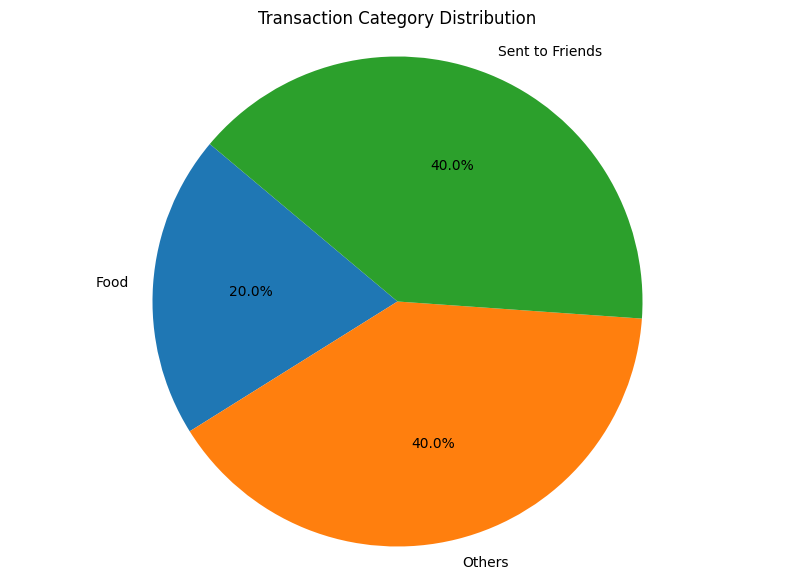

In [32]:
from collections import Counter
import matplotlib.pyplot as plt

# categorize a single transaction
def categorize_transaction(transaction):
    headers = {
        "Content-Type": "application/json",
        "api-key": GPT4V_KEY,
    }

    payload = {
        "messages": [
            {
                "role": "user",
                "content": f"Categorize this transaction into one of the categories and just give the category name(Food, Transportation, Entertainment, Healthcare, Utilities, Sent to Friends, Others): {transaction}"
            }
        ],
        "temperature": 0.5,
        "top_p": 1,
        "max_tokens": 60
    }

    try:
        response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
        response.raise_for_status()
        category = response.json()['choices'][0]['message']['content'].strip()
    except requests.RequestException as e:
        print(f"Failed to categorize transaction '{transaction}'. Error: {e}")
        category = "Unknown"
    return category

# categorize all transactions
def categorize_transactions(transactions):
    categorized = [categorize_transaction(transaction) for transaction in transactions[:5]]
    return categorized

# calculate and display percentages
def calculate_and_display_percentages(categories):
    category_counts = Counter(categories)
    total_transactions = len(categories)
    percentages = {category: (count / total_transactions) * 100 for category, count in category_counts.items()}
    
    # print percentages
    print("Transaction Category Percentages:")
    for category, percentage in percentages.items():
        print(f"{category}: {percentage:.2f}%")
    
    # pie chart
    labels = percentages.keys()
    sizes = percentages.values()
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal') 
    plt.title("Transaction Category Distribution")
    plt.show()

    return percentages

# Categorize transactions
categories = categorize_transactions(transactions)

# Calculate and display the percentages
percentages = calculate_and_display_percentages(categories)


Risk Score:  45


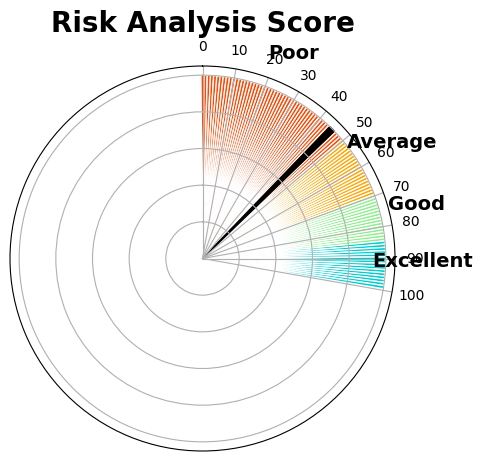

In [62]:
# Function to get risk analysis score from GPT model
def get_risk_analysis_score(transactions):
    headers = {
        "Content-Type": "application/json",
        "api-key": GPT4V_KEY,
    }

    transaction_text = "\n".join(transactions)
    prompt = f"Analyze the risk of the following transactions and provide an estimate risk score between 1 and 100 based on the companies or people the transactions are with (just an estimate number between 1 to 100). Return only the Integer value from 1-100 nothing else:\n{transaction_text}"

    payload = {
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.5,
        "top_p": 1,
        "max_tokens": 60
    }

    try:
        response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
        response.raise_for_status()  
        risk_score = int(response.json()['choices'][0]['message']['content'].strip())
        print("Risk Score: ", risk_score)
    except requests.RequestException as e:
        print(f"Failed to get risk analysis score. Error: {e}")
        risk_score = 0
    return risk_score

# Display risk analysis score as a horizontal bar chart
def display_risk_analysis_score(risk_score):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': 'polar'})
    
    plt.title('Risk Analysis Score', size=20, weight='bold', position=(0.5, 1.1))
    
    # the gauge segments
    colors = ['#ff4500', '#ffa500', '#90ee90', '#00ced1']
    labels = ['Poor', 'Average', 'Good', 'Excellent']
    segments = [range(0, 50), range(50, 70), range(70, 85), range(85, 100)]
    
    for i, segment in enumerate(segments):
        ax.bar(
            np.deg2rad(segment),
            [1] * len(segment),
            width=np.deg2rad(1),
            color=colors[i],
            edgecolor='white'
        )
    
    ax.bar(
        np.deg2rad([risk_score]),
        [1],
        width=np.deg2rad(2),
        color='black',
        edgecolor='black'
    )
    
    # Add the labels
    for i, label in enumerate(labels):
        ax.text(
            np.deg2rad(np.mean(segments[i])),
            1.2,
            label,
            horizontalalignment='center',
            size=14,
            weight='bold'
        )
    
    ax.set_yticklabels([])
    ax.set_xticks(np.deg2rad(np.linspace(0, 100, 11)))
    ax.set_xticklabels([str(i) for i in range(0, 101, 10)])
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
    plt.show()


# risk analysis score from GPT model
risk_score = get_risk_analysis_score(transactions)

# risk analysis score as a chart
display_risk_analysis_score(risk_score)

In [4]:
def interact_with_chatbot(messages, api_key, endpoint):
    headers = {
        "Content-Type": "application/json",
        "api-key": api_key,
    }

    payload = {
        "messages": messages,
        "temperature": 0.7,
        "top_p": 0.95,
        "max_tokens": 800
    }

    try:
        response = requests.post(endpoint, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Failed to make the request. Error: {e}")
        return None


# Initial message to the chatbot
messages = [
    {
        "role": "system",
        "content": "You are an AI assistant that helps people find financial information and provide personalized advice based on their bank statements."
    },
    {
        "role": "assistant",
        "content": "I have extracted your transactions from the uploaded bank statement. How can I assist you today?"
    }
]

# extracted transactions to the chat history
transactions_message = {
    "role": "assistant",
    "content": "Here are the transactions I found:\n" + "\n".join(transactions)
}
messages.append(transactions_message)

# Interaction loop
while True:
    user_query = input("You: ")
    
    if user_query.lower() in ['quit', 'exit', 'q']:
        print("Exiting the chatbot. Have a nice day!")
        break
    
    user_message = {
        "role": "user",
        "content": user_query
    }
    messages.append(user_message)

    response = interact_with_chatbot(messages, GPT4V_KEY, GPT4V_ENDPOINT)
    
    if response is not None:
        assistant_message = response['choices'][0]['message']['content'].strip()
        print(f"Query: {user_query}")
        print(f"AI: {assistant_message}")
        messages.append({"role": "assistant", "content": assistant_message})
    else:
        print("AI: Sorry, I couldn't process that. Please try again.")


Query: What was my last transaction?
AI: Your last transaction was on 30 June 2024. It was a UPI payment to "Mother Dairy Bo" for an amount of ₹20.00. After this transaction, your account balance was ₹169.26.
Query: Did I ever buy momos?
AI: Yes, you did purchase momos. On 22 June 2024, you made a UPI payment to "Chetan Momos" for an amount of ₹310.00.
Query: What was the amount I spent on this?
AI: You spent ₹310.00 on purchasing momos from "Chetan Momos" on 22 June 2024.
Exiting the chatbot. Have a nice day!


In [9]:
# modified chatbot
import requests
import json
initial_messages = [
    {
        "role": "system",
        "content": """You are an AI assistant that helps people find financial information and provide 
        personalized advice based on their bank statements. Focus only on transactions and Bank of Baroda information.
        Do not provide information about other banks. If asked about other banks, politely refuse and redirect to Bank of Baroda."""
    },
    {
        "role": "assistant",
        "content": """For Bank of Baroda related queries, refer to this website: https://www.bankofbaroda.in/
        If asked about other banks, respond with: 'I'm sorry, but I can only provide information about Bank of Baroda. 
        How can I assist you with Bank of Baroda services or your transactions?'
        Always try to promote Bank of Baroda services when appropriate."""
    },
    {
        "role": "assistant",
        "content": "I have extracted your transactions from the uploaded bank statement. How can I assist you with your transactions or Bank of Baroda services today?"
    }
]

def interact_with_chatbot(messages, api_key, endpoint):
    headers = {
        "Content-Type": "application/json",
        "api-key": api_key,
    }

    payload = {
        "messages": messages,
        "temperature": 0.2,
        "top_p": 0.95,
        "max_tokens": 500
    }

    try:
        response = requests.post(endpoint, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Failed to make the request. Error: {e}")
        return None

def chatbot(user_query):
    global transactions, initial_messages
    messages = initial_messages.copy()

    # Ensure messages are properly formatted
    validated_messages = []
    for msg in messages:
        if isinstance(msg, dict) and 'role' in msg and 'content' in msg:
            validated_messages.append(msg)

    # Add the transactions to the conversation
    transactions_message = {
        "role": "assistant",
        "content": "Here are the transactions:\n" + "\n".join(transactions) + "\nKeep the information limited to the transactions, do not utter other information"
    }
    if not any(msg['role'] == 'assistant' and 'transactions' in msg['content'] for msg in validated_messages):
        validated_messages.append(transactions_message)

    if user_query.lower() in ['quit', 'exit', 'q']:
        validated_messages.append({"role": "user", "content": user_query})
        validated_messages.append({"role": "assistant", "content": "Session ended."})
        return {"response": "Session ended.", "messages": validated_messages}

    user_message = {"role": "user", "content": user_query}
    validated_messages.append(user_message)

    response = interact_with_chatbot(validated_messages, GPT4V_KEY, GPT4V_ENDPOINT)

    if response is not None:
        assistant_message = response['choices'][0]['message']['content'].strip()
        validated_messages.append({"role": "assistant", "content": assistant_message})
        return {"response": assistant_message, "messages": validated_messages}
    else:
        error_message = "Sorry, something went wrong."
        validated_messages.append({"role": "assistant", "content": error_message})
        return {"response": error_message, "messages": validated_messages}

# Test the chatbot function
user_query = "credit card options in kotak mahindra."
result = chatbot(user_query)
print(json.dumps(result, indent=2))

{
  "response": "I'm sorry, but I can only provide information about Bank of Baroda. How can I assist you with Bank of Baroda services or your transactions?",
  "messages": [
    {
      "role": "system",
      "content": "You are an AI assistant that helps people find financial information and provide \n        personalized advice based on their bank statements. Focus only on transactions and Bank of Baroda information.\n        Do not provide information about other banks. If asked about other banks, politely refuse and redirect to Bank of Baroda."
    },
    {
      "role": "assistant",
      "content": "For Bank of Baroda related queries, refer to this website: https://www.bankofbaroda.in/\n        If asked about other banks, respond with: 'I'm sorry, but I can only provide information about Bank of Baroda. \n        How can I assist you with Bank of Baroda services or your transactions?'\n        Always try to promote Bank of Baroda services when appropriate."
    },
    {
      "